In [1]:
import pandas as pd
import geopandas as gdp
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
from shapely import wkt
import contextily as ctx
from sklearn.cluster import KMeans
import numpy as np

In [2]:
crs = {'init':'EPSG:4326'} # for setting crs when loading gdp

In [18]:
df = pd.read_csv(r'../../Machine Learning/Data Incubator/Motor_Vehicle_Collisions_-_Crashes.csv')

C:\Users\Lenovo\Anaconda3\envs\cs231n\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# Convert the CRASH DATE and CRASH TIME columns to datetime type
df.iloc[:, 0:2] = df.iloc[:, 0:2].apply(pd.to_datetime, errors='coerce')

In [20]:
# df.info()

In [21]:
# working with smaller data size to start
df = df[df['CRASH DATE'] >= '2019-01-01'].reset_index(drop=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277173 entries, 0 to 277172
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     277173 non-null  datetime64[ns]
 1   CRASH TIME                     277173 non-null  datetime64[ns]
 2   BOROUGH                        180139 non-null  object        
 3   ZIP CODE                       180089 non-null  object        
 4   LATITUDE                       254571 non-null  float64       
 5   LONGITUDE                      254571 non-null  float64       
 6   LOCATION                       254571 non-null  object        
 7   ON STREET NAME                 209323 non-null  object        
 8   CROSS STREET NAME              135754 non-null  object        
 9   OFF STREET NAME                67822 non-null   object        
 10  NUMBER OF PERSONS INJURED      277173 non-null  float64       
 11  

In [23]:
df.sort_values(['CRASH DATE'], ascending = False)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
11522,2020-07-31,2020-08-07 09:00:00,MANHATTAN,10030,40.815975,-73.94322,POINT (-73.94322 40.815975),WEST 136 STREET,7 AVENUE,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,4333761,Sedan,NaN,NaN,NaN,NaN
18264,2020-07-31,2020-08-07 16:09:00,STATEN ISLAND,10308,40.547130,-74.14045,POINT (-74.14045 40.54713),HYLAN BOULEVARD,WATERSIDE PARKWAY,NaN,...,Unspecified,Unspecified,NaN,NaN,4333809,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN
7199,2020-07-31,2020-08-07 09:00:00,BROOKLYN,11249,40.703120,-73.96443,POINT (-73.96443 40.70312),ROSS STREET,WYTHE AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4334029,Sedan,NaN,NaN,NaN,NaN
11450,2020-07-31,2020-08-07 15:30:00,BRONX,10454,40.801000,-73.91371,POINT (-73.91371 40.801),EAST 133 STREET,WILLOW AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4333859,Box Truck,Taxi,NaN,NaN,NaN
7249,2020-07-31,2020-08-07 03:02:00,NaN,NaN,NaN,NaN,NaN,HYLAN BOULEVARD,CLOVE ROAD,NaN,...,Unspecified,NaN,NaN,NaN,4333584,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274877,2019-01-01,2020-08-07 09:58:00,NaN,NaN,40.770390,-73.91771,POINT (-73.91771 40.77039),31 STREET,HOYT AVENUE SOUTH,NaN,...,Unspecified,NaN,NaN,NaN,4060700,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
268424,2019-01-01,2020-08-07 06:32:00,NaN,NaN,40.861310,-73.92124,POINT (-73.92124 40.86131),WEST 202 STREET,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4061625,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
274220,2019-01-01,2020-08-07 04:10:00,MANHATTAN,10075,40.774967,-73.95680,POINT (-73.9568 40.774967),3 AVENUE,EAST 80 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4060620,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
272783,2019-01-01,2020-08-07 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79 WEST DRIVE,...,Driver Inexperience,NaN,NaN,NaN,4060555,Bike,Bike,NaN,NaN,NaN


In [24]:
# Getting rid of accidents with NaN locatation
df = df.dropna(subset=['LOCATION']).reset_index(drop=True)

In [25]:
df[(df['LATITUDE']==0)|(df['LONGITUDE']==0)].head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
166,2019-01-30,2020-08-07 13:34:00,MANHATTAN,10007,0.0,0.0,POINT (0 0),NaN,NaN,101 BARCLAY STREET,...,NaN,NaN,NaN,NaN,4072246,Sedan,NaN,NaN,NaN,NaN
176,2019-01-29,2020-08-07 11:07:00,NaN,NaN,0.0,0.0,POINT (0 0),KINGS HIGHWAY,EAST 32 STREET,NaN,...,NaN,NaN,NaN,NaN,4072149,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
180,2019-01-29,2020-08-07 18:47:00,NaN,NaN,0.0,0.0,POINT (0 0),WEST 230 STREET,BROADWAY,NaN,...,NaN,NaN,NaN,NaN,4072064,Taxi,NaN,NaN,NaN,NaN
187,2020-06-16,2020-08-07 02:59:00,QUEENS,11370,0.0,0.0,POINT (0 0),NaN,NaN,25-46 82 STREET,...,NaN,NaN,NaN,NaN,4321046,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
188,2019-10-09,2020-08-07 05:10:00,BROOKLYN,11207,0.0,0.0,POINT (0 0),NaN,NaN,561 WYONA STREET,...,NaN,NaN,NaN,NaN,4220275,NaN,NaN,NaN,NaN,NaN


In [26]:
# Get rid of locations that are zero for now
df = df[(df['LATITUDE']!=0)|(df['LONGITUDE']!=0)].reset_index(drop=True)

In [27]:
df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-08-05,2020-08-07 01:50:00,BROOKLYN,11207,40.687984,-73.907430,POINT (-73.90743 40.687984),NaN,NaN,662 CENTRAL AVENUE,...,Unspecified,NaN,NaN,NaN,4183103,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2019-11-01,2020-08-07 18:30:00,NaN,NaN,40.835117,-73.873910,POINT (-73.87391 40.835117),BRONX RIVER PARKWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4235723,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
2,2020-07-31,2020-08-07 18:00:00,NaN,NaN,40.746650,-73.969124,POINT (-73.969124 40.74665),FDR DRIVE,NaN,NaN,...,NaN,NaN,NaN,NaN,4333751,Sedan,NaN,NaN,NaN,NaN
3,2019-02-18,2020-08-07 19:00:00,NaN,NaN,40.654488,-73.979034,POINT (-73.979034 40.654488),19 STREET,11 AVENUE,NaN,...,NaN,NaN,NaN,NaN,4082969,Sedan,NaN,NaN,NaN,NaN
4,2019-08-05,2020-08-07 20:00:00,NaN,NaN,40.689510,-73.948044,POINT (-73.948044 40.68951),MARCY AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,4183749,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254210,2019-01-13,2020-08-07 20:40:00,STATEN ISLAND,10304,40.591020,-74.100914,POINT (-74.100914 40.59102),RICHMOND ROAD,FOUR CORNERS ROAD,NaN,...,Unspecified,NaN,NaN,NaN,4066151,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
254211,2019-01-07,2020-08-07 07:43:00,BRONX,10457,40.847027,-73.898070,POINT (-73.89807 40.847027),WASHINGTON AVENUE,EAST TREMONT AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4063469,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN
254212,2019-01-19,2020-08-07 11:25:00,NaN,NaN,40.684116,-73.832730,POINT (-73.83273 40.684116),109 STREET,LIBERTY AVENUE,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,4057680,Pick-up Truck,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
254213,2019-01-08,2020-08-07 23:45:00,BROOKLYN,11234,40.608204,-73.920715,POINT (-73.920715 40.608204),AVENUE V,FLATBUSH AVENUE,NaN,...,NaN,NaN,NaN,NaN,4064254,Sedan,NaN,NaN,NaN,NaN


In [28]:
# Use CRS do define it at start
gdf = gdp.GeoDataFrame(
    df, geometry=gdp.points_from_xy(df.LONGITUDE, df.LATITUDE), crs=crs)

C:\Users\Lenovo\Anaconda3\envs\cs231n\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [29]:
gdf.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
0,2019-08-05,2020-08-07 01:50:00,BROOKLYN,11207,40.687984,-73.907430,POINT (-73.90743 40.687984),NaN,NaN,662 CENTRAL AVENUE,...,NaN,NaN,NaN,4183103,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.90743 40.68798)
1,2019-11-01,2020-08-07 18:30:00,NaN,NaN,40.835117,-73.873910,POINT (-73.87391 40.835117),BRONX RIVER PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4235723,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,POINT (-73.87391 40.83512)
2,2020-07-31,2020-08-07 18:00:00,NaN,NaN,40.746650,-73.969124,POINT (-73.969124 40.74665),FDR DRIVE,NaN,NaN,...,NaN,NaN,NaN,4333751,Sedan,NaN,NaN,NaN,NaN,POINT (-73.96912 40.74665)
3,2019-02-18,2020-08-07 19:00:00,NaN,NaN,40.654488,-73.979034,POINT (-73.979034 40.654488),19 STREET,11 AVENUE,NaN,...,NaN,NaN,NaN,4082969,Sedan,NaN,NaN,NaN,NaN,POINT (-73.97903 40.65449)
4,2019-08-05,2020-08-07 20:00:00,NaN,NaN,40.689510,-73.948044,POINT (-73.948044 40.68951),MARCY AVENUE,NaN,NaN,...,NaN,NaN,NaN,4183749,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (-73.94804 40.68951)


In [30]:
gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
# Now convert it
gdf = gdf.to_crs("EPSG:3857")

In [32]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

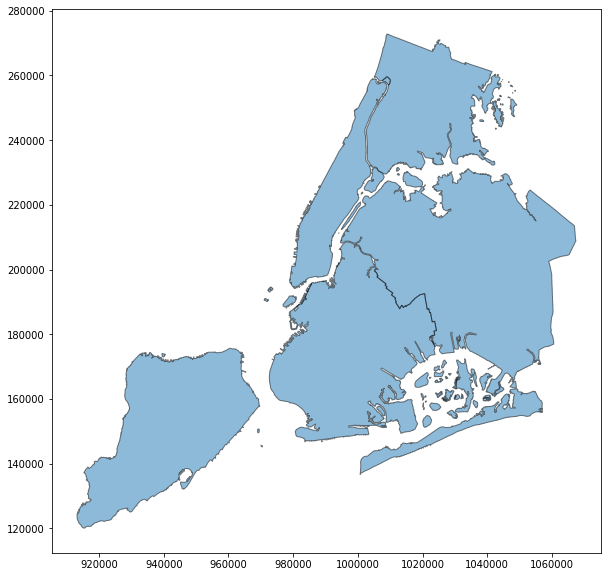

In [3]:
nyc = gdp.read_file(gdp.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k',)

In [4]:
nyc.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
# Convert to WGS 84 coordinate system
# The regular Latitude and Longtitude coordinates
nyc = nyc.to_crs("EPSG:4326")

In [35]:
# Convert to Web Mercator coordinate system
# Must have that to fit map on top
nyc = nyc.to_crs("EPSG:3857")

In [6]:
nyc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

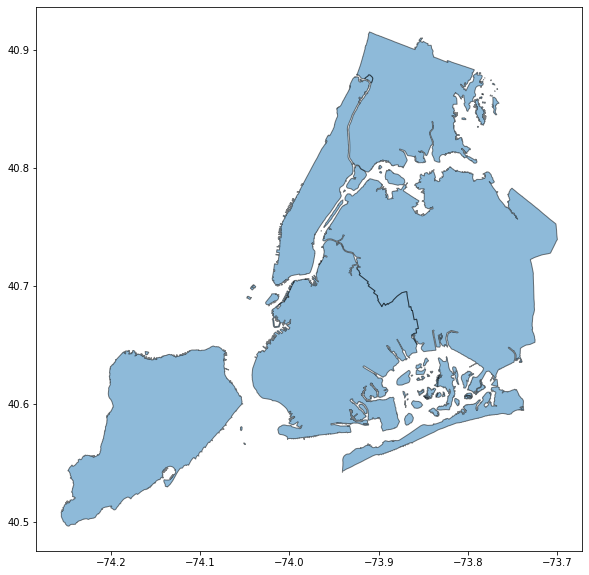

In [7]:
ax =nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

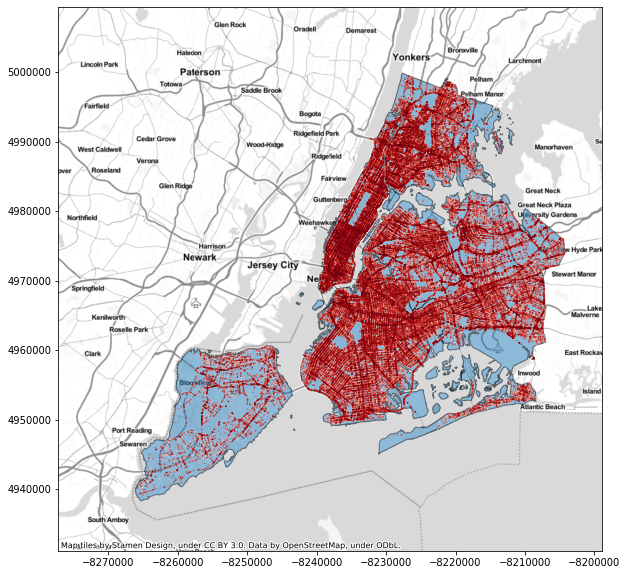

In [48]:
# df1 = gdp.read_file(gdp.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE)
gdf.plot(ax=ax, cmap='Reds', markersize=.05)
plt.show()

In [9]:
streat_map = gdp.read_file('NYC_shapefile/CHS_2009_DOHMH_2010B.shp')

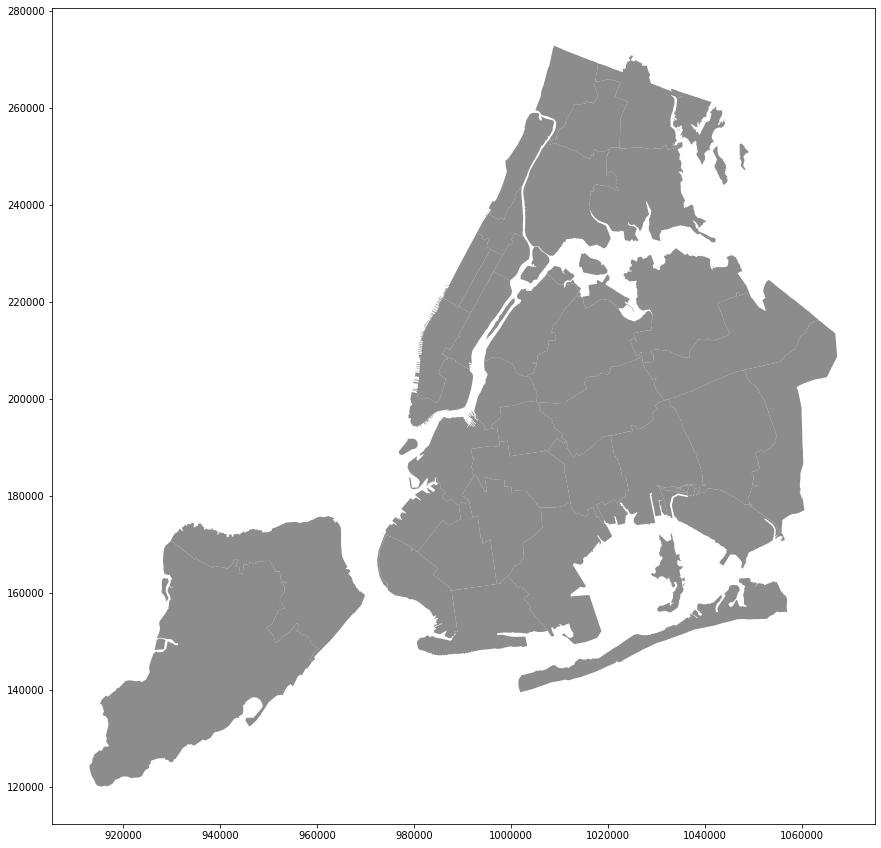

In [16]:
fig, ax = plt.subplots(figsize = (15,15))
streat_map.plot(ax = ax, alpha = .9, color = 'grey')

In [18]:
# Place on map locations of accidents

In [32]:
geo = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

In [35]:
geo_df = gdp.GeoDataFrame(df, geometry = geo)

In [13]:
# Using Nominatim api to find coordinates if street is avilable but coordinates are not

Query examples:

https://nominatim.openstreetmap.org/search?q=564+1st+ave+new+york+ny+10016&format=json

https://nominatim.openstreetmap.org/ui/search.html?street=564+1st+ave&city=nyc
